<a href="https://colab.research.google.com/github/sundarjhu/Astrostatistics2025/blob/main/Lesson15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1-sample Kolmogorov-Smirnov test**
###Compute a $\chi^2$ fit to the data from Problem 5d on the midterm exam.
###Are the residues drawn from a Standard Normal?

In [ ]:
from astropy.table import Table
import numpy as np
from scipy.stats import kstest

def get_residues(infile = 'https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2021/Exams/midterm_p5.csv'):
    """
    Given data for problem 5 in midterm_p5.csv, perform chi-squared
    minimisation to obtain the best-fit values for the slope and intercept.
    Return the residues from the best model fit.
    """
    def get_sums(x, y, y_err, k, l):
        """
        Compute sums of the form
        SUM(x^k * y^l / y_err^2)
        for the data
        """
        return (x**k * y**l / y_err**2).sum()

    t = Table.read(infile, format = 'csv')

    s00 = get_sums(t['x'], t['y'], t['y_err'], 0, 0)
    s10 = get_sums(t['x'], t['y'], t['y_err'], 1, 0)
    s01 = get_sums(t['x'], t['y'], t['y_err'], 0, 1)
    s11 = get_sums(t['x'], t['y'], t['y_err'], 1, 1)
    s20 = get_sums(t['x'], t['y'], t['y_err'], 2, 0)

    #The best-fit parameter values
    A = np.matrix([[s20, s10], [s10, s00]])
    B = np.matrix([[s11], [s01]])
    theta = np.matmul(np.linalg.inv(A), B)
    #print("The best-fit slope is {}".format(np.round(theta[0, 0], decimals = 3)))
    #print("The best-fit intercept is {}".format(np.round(theta[1, 0], decimals = 3)))

    #Compute and return the residues
    ymod = theta[0, 0] * t['x'] + theta[1, 0]
    residues = (t['y'] - ymod) / t['y_err']
    return residues

residues = get_residues()
#Perform the KS test to test the hypothesis that these residues are drawn from a Standard Normal
print("Null hypothesis: residues are drawn from the Standard Normal distribution.")
D_KS, p_value = kstest(residues, 'norm')
alpha = 0.05
print("KS statistic: {}".format(np.round(D_KS, decimals = 3)))
print("p-value: {}".format(np.round(p_value, decimals = 3)))
if p_value < alpha:
  print("The p-value from the KS test is less than the significance. The null hypothesis is rejected!")
  print("Strong evidence that the sample is NOT drawn from a Standard Normal distribution!")
else:
  print("The p-value from the KS test is >= the significance. Null hypothesis cannot be rejected!")
  print("The sample is drawn from a Standard Normal distribution!")


Null hypothesis: residues are drawn from the Standard Normal distribution.
KS statistic: 0.042
p-value: 0.994
The p-value from the KS test is >= the significance. Null hypothesis cannot be rejected!
The sample is drawn from a Standard Normal distribution!


##**Note: in the above, we compared a sample to the Standard Normal distribution, so no extra parameters (loc, scale) were passed to `scipy.stats.norm`.**
##If you have to compare to a general Gaussian distribution (loc != 0, scale != 1), consult the documentation for the `args` keyword.
##In general, this is quite painful. It is much easier to just standardise your data to the model parameters, as the following example shows.

In [ ]:
from scipy.stats import uniform, norm, kstest
#Draw samples from a Uniform distribution over [-2, 2]
x = uniform.rvs(loc = -2, scale = 4, size = 10)
#Test the hypothesis that this sample is drawn from a Uniform distribution over [-3, 0]
Model_loc = -3
Model_scale = 3
y = (x - Model_loc) / Model_scale
#Perform the KS test to test the hypothesis that this transposed sample is drawn from a Standard Uniform distribution
#       This is the same as testing whether the original sample is drawn from a Uniform(-3, 0)
print("Null hypothesis: residues are drawn from the Standard Uniform distribution.")
D_KS, p_value = kstest(y, 'uniform')
alpha = 0.05
print("KS statistic: {}".format(np.round(D_KS, decimals = 3)))
print("p-value: {}".format(np.round(p_value, decimals = 3)))
if p_value < alpha:
  print("The p-value from the KS test is less than the significance. The null hypothesis is rejected!")
else:
  print("The p-value from the KS test is >= the significance. Null hypothesis cannot be rejected!")

Null hypothesis: residues are drawn from the Standard Uniform distribution.
KS statistic: 0.535
p-value: 0.003
The p-value from the KS test is less than the significance. The null hypothesis is rejected!


#**What if you aren't given the model parameters? Can you estimate them from the data then use the KS test?**
#**DAS IST VERBOTEN!! See p. 108-109 of Feigelsen & Babu**

In [ ]:
seed = 10001

#**Comparing the Kolmogorov-Smirnov and Anderson-Darling tests**
##We will now generate a sample from the Student's $t$ distribution, and test whether it is drawn from a Standard Normal.
##The null hypothesis should be rejected in this case, but the KS test is not sensitive to differences in the tails, so it's not as good as the AD test in this case.

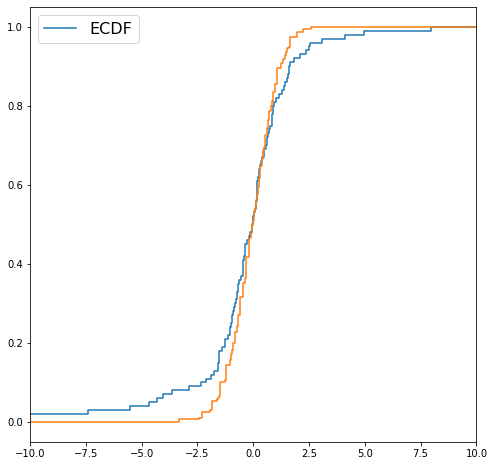

In [ ]:
#Generate data for test
import numpy as np
from scipy.stats import t
np.random.seed(seed)
df = 2
x = t.rvs(df, size = 100)
alpha = 0.05
#Visual comparison of data ECDF to CDF of a Standard Normal
from matplotlib import pyplot as plt
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(x)
_ = plt.figure(figsize = (8, 8))
plt.step(ecdf.x, ecdf.y, where = 'mid', label = 'ECDF')
plt.step(ecdf.x, norm.cdf(ecdf.x))
_ = plt.legend(loc = 'best', fontsize = 16)
_ = plt.xlim(-10, 10)


In [ ]:
"""This function performs the KS test and returns 0 if H0 is rejected"""
def do_KS_test(x, doprint = False):
  from scipy.stats import kstest
  ksstat, pvalue_ks = kstest(x, 'norm')
  if doprint:
    print("--------Kolmogorov-Smirnov Test--------")
  if pvalue_ks > alpha:
    if doprint:
      print("p-value = {}, > significance; the null hypothesis cannot be rejected.".format(np.format_float_scientific(pvalue_ks, precision = 2)))
      print("The data is drawn from a normal distribution!")
    return 1
  else:
    if doprint:
      print("p-value = {}, <= significance; the null hypothesis is rejected.".format(np.format_float_scientific(pvalue_ks, precision = 2)))
      print("Strong evidence that data is not drawn from a normal distribution!")
    return 0

"""This function performs the AD test and returns 0 if H0 is rejected"""
def do_AD_test(x, doprint = False):
  from scipy.stats import anderson
  adstat, adcrit, pvalue_ad = anderson(x, dist = 'norm')
  if doprint:
    print("--------Anderson-Darling Test--------")
  k = np.searchsorted(np.array(pvalue_ad[::-1]), 100 * alpha, side = 'left') #reverse search because pvalue_ad is sorted in descending order
  if adcrit[k] >= adstat:
    if doprint:
      print("Observed AD statistic = {} < {} = AD statistic for 5% significance; the null hypothesis cannot be rejected."\
            .format(np.round(adstat, decimals = 2), np.round(adcrit[k], decimals = 2)))
      print("The data is drawn from a normal distribution!")
    return 1
  else:
    if doprint:
      print("Observed AD statistic = {} > {} = AD statistic for 5% significance; the null hypothesis is rejected.".\
            format(np.round(adstat, decimals = 2), np.round(adcrit[k], decimals = 2)))
      print("Strong evidence that data is not drawn from a normal distribution!")
    return 0

In [ ]:
#Run one test each
_ = do_KS_test(x, doprint = True)
_ = do_AD_test(x, doprint = True)

--------Kolmogorov-Smirnov Test--------
p-value = 1.38e-01, > significance; the null hypothesis cannot be rejected.
The data is drawn from a normal distribution!
--------Anderson-Darling Test--------
Observed AD statistic = 8.13 > 0.76 = AD statistic for 5% significance; the null hypothesis is rejected.
Strong evidence that data is not drawn from a normal distribution!


# Wilcoxon-Mann-Whitney $U$-test

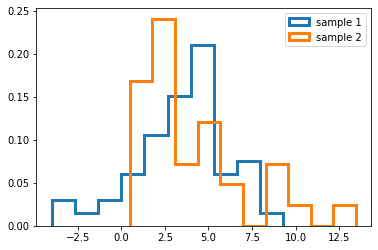

The observed Mann-Whitney U statistic has p-value 9.28e-01 > the significance. No evidence that samples have different population means.


In [ ]:
#Samples drawn from normal and chi2 distributions WITH THE SAME POPULATION MEAN
from scipy.stats import norm, chi2, mannwhitneyu
df = 4
np.random.seed(seed)
x1 = norm.rvs(loc = df, scale = np.sqrt(2 * df), size = 50)
x2 = chi2.rvs(df, size = 32)
from matplotlib import pyplot as plt
plt.hist(x1, histtype = 'step', label = 'sample 1', lw = 3, density = True)
plt.hist(x2, histtype = 'step', label = 'sample 2', lw = 3, density = True)
plt.legend(loc = 'best')
plt.show()
alpha = 0.05
ustat, pvalue = mannwhitneyu(x1, x2, alternative = 'two-sided')
if pvalue <= alpha:
  print("The observed Mann-Whitney U statistic has p-value {} <= the significance. H0 is rejected!".format(np.format_float_scientific(pvalue, precision = 2)))
else:
  print("The observed Mann-Whitney U statistic has p-value {} > the significance. No evidence that samples have different population means.".format(np.format_float_scientific(pvalue, precision = 2)))

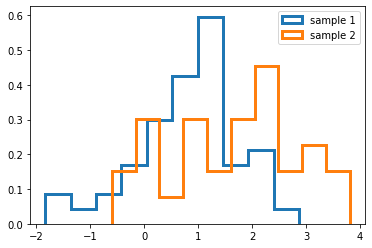

The observed Mann-Whitney U statistic has p-value 2.56e-03 <= the significance. H0 is rejected!


1.0606601717798212

In [ ]:
#Samples drawn from normal distributions WITH DIFFERENT POPULATION MEANS
from scipy.stats import norm, mannwhitneyu
np.random.seed(seed)
x1 = norm.rvs(loc = 1, size = 50)
x2 = norm.rvs(loc = 1.5, size = 30)
from matplotlib import pyplot as plt
plt.hist(x1, histtype = 'step', label = 'sample 1', lw = 3, density = True)
plt.hist(x2, histtype = 'step', label = 'sample 2', lw = 3, density = True)
plt.legend(loc = 'best')
plt.show()
alpha = 0.05
ustat, pvalue = mannwhitneyu(x1, x2, alternative = 'two-sided')
if pvalue <= alpha:
  print("The observed Mann-Whitney U statistic has p-value {} <= the significance. H0 is rejected!".format(np.format_float_scientific(pvalue, precision = 2)))
else:
  print("The observed Mann-Whitney U statistic has p-value {} > the significance. No evidence that samples have different population means.".format(np.format_float_scientific(pvalue, precision = 2)))

# Box plot and violin plot demo

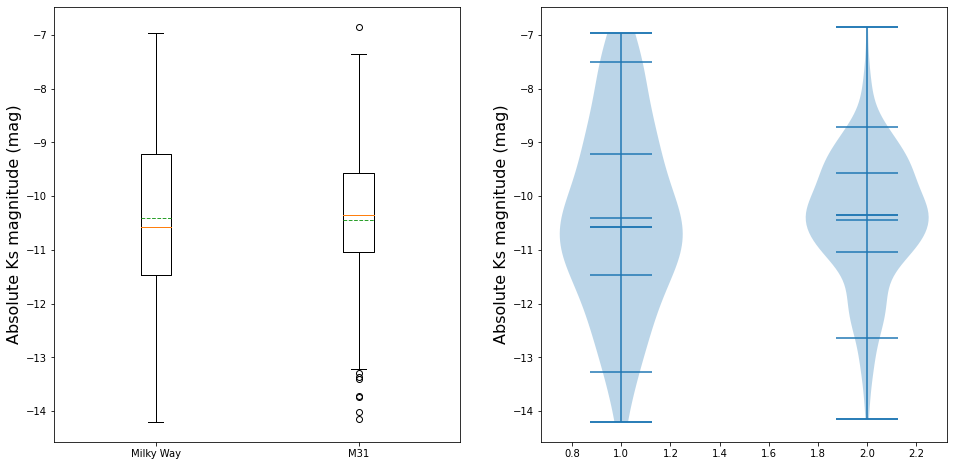

In [ ]:
#Ks-band luminosity function of globular clusters in the Milky Way and Andromeda
import numpy as np
from matplotlib import pyplot as plt

data1 = np.loadtxt('https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2020/python/datasets/globular_clusters/MW_GCs.txt')
data2 = np.loadtxt('https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2020/python/datasets/globular_clusters/M31_GCs.txt')
#M31 magnitudes not corrected for distance!
data2 = data2 - 24.9

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
_ = ax[0].boxplot([data1, data2], meanline = True, showmeans = True, labels = ['Milky Way', 'M31'])
_ = ax[0].set_ylabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})

_ = ax[1].violinplot([data1, data2], showmeans = True, showextrema = True, showmedians = True, \
                     quantiles = [[0, 0.05, 0.25, 0.5, 0.75, 0.95, 1], [0, 0.05, 0.25, 0.5, 0.75, 0.95, 1]])#, labels = ['Milky Way', 'M31'])
_ = ax[1].set_ylabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})

# Histogram binning choices

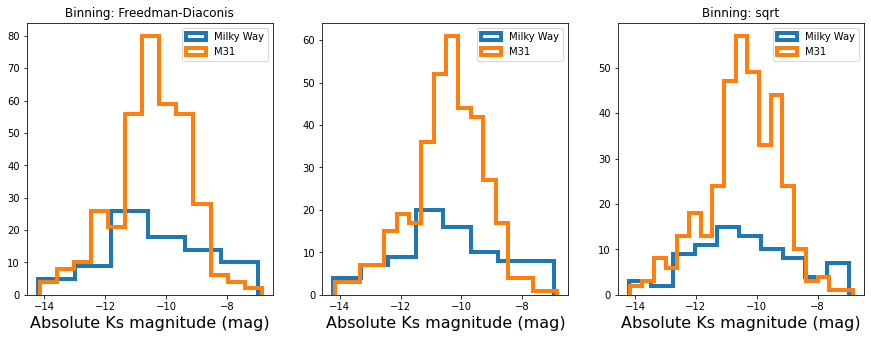

In [ ]:
#Ks-band luminosity function of globular clusters in the Milky Way and Andromeda
import numpy as np
from matplotlib import pyplot as plt

data1 = np.loadtxt('https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2020/python/datasets/globular_clusters/MW_GCs.txt')
data2 = np.loadtxt('https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2020/python/datasets/globular_clusters/M31_GCs.txt')
#M31 magnitudes not corrected for distance!
data2 = data2 - 24.9

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
_ = ax[0].hist(data1, histtype = 'step', bins = 'scott', label = 'Milky Way', lw = 4)
_ = ax[0].hist(data2, histtype = 'step', bins = 'scott', label = 'M31', lw = 4)
_ = ax[0].legend(loc = 'best')
_ = ax[0].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})
_ = ax[0].set_title('Binning: Scott')

_ = ax[1].hist(data1, histtype = 'step', bins = 'fd', label = 'Milky Way', lw = 4)
_ = ax[1].hist(data2, histtype = 'step', bins = 'fd', label = 'M31', lw = 4)
_ = ax[1].legend(loc = 'best')
_ = ax[1].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})
_ = ax[0].set_title('Binning: Freedman-Diaconis')

_ = ax[2].hist(data1, histtype = 'step', bins = 'sqrt', label = 'Milky Way', lw = 4)
_ = ax[2].hist(data2, histtype = 'step', bins = 'sqrt', label = 'M31', lw = 4)
_ = ax[2].legend(loc = 'best')
_ = ax[2].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})
_ = ax[2].set_title('Binning: sqrt')


# Kernel density estimate demo

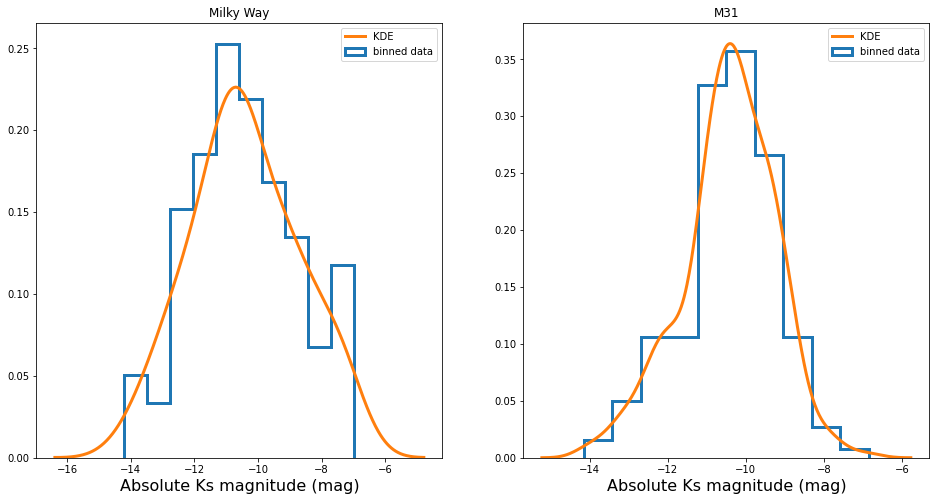

In [ ]:
from statsmodels.nonparametric.kde import KDEUnivariate
    #   Instead, compute a KDE and find the location of the maximum.
kde1 = KDEUnivariate(data1); kde1.fit()
kde2 = KDEUnivariate(data2); kde2.fit()
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
_ = ax[0].hist(data1, histtype = 'step', label = 'binned data', density = True, lw = 3)
_ = ax[0].plot(kde1.support, kde1.density, lw = 3, label = 'KDE')
_ = ax[0].set_title('Milky Way')
_ = ax[0].legend(loc = 'best')
_ = ax[0].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})
_ = ax[1].hist(data2, histtype = 'step', label = 'binned data', density = True, lw = 3)
_ = ax[1].plot(kde2.support, kde2.density, lw = 3, label = 'KDE')
_ = ax[1].set_title('M31')
_ = ax[1].legend(loc = 'best')
_ = ax[1].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})

##Let's do some KDE
#kde = KDEUnivariate(xx)
#plt.plot(kde.support, kde.density, lw = 3, label = 'KDE from samples', zorder = 10)
